In [1]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import math

import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_func

import pennylane as qml

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [2]:
filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

print("Raw data shape:", data_X.shape)

data_X = data_X.astype(np.float32)

# log + normalize
data_X = np.log1p(data_X)
data_X = data_X / data_X.max()

# map to [-1, 1]
data_X = 2.0 * data_X - 1.0

Raw data shape: (1000, 64, 64)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def quantum_patch_circuit(inputs):
    """
    inputs: (Batch_Size, 4) tensor
    Output: (Batch_Size, 4) tensor of expectations
    """
    # Shift input x from [-1, 1] to theta in [0, pi]
    # This ensures the encoding is monotonic and reversible
    scaled_inputs = (inputs + 1.0) * (np.pi / 2.0)
    
    # Encode 4 pixels into 2 qubits
    qml.RY(scaled_inputs[:, 0], wires=0)
    qml.RZ(scaled_inputs[:, 1], wires=0)
    qml.RY(scaled_inputs[:, 2], wires=1)
    qml.RZ(scaled_inputs[:, 3], wires=1)
    
    # Entangle
    qml.CNOT(wires=[0, 1])
    
    # Measure 4 observables to preserve information dimensionality
    # These capture both individual pixel values and their correlations
    return [qml.expval(qml.PauliZ(0)), 
            qml.expval(qml.PauliZ(1)), 
            qml.expval(qml.PauliX(0) @ qml.PauliX(1)),
            qml.expval(qml.PauliY(0) @ qml.PauliY(1))]

In [10]:
def process_images_vectorized(images):
    """
    Break 64x64 images into 2x2 patches and embed them in batches.
    images: (N, 1, 64, 64)
    returns: (N, 4, 32, 32)
    """
    N, C, H, W = images.shape
    
    patches = F.unfold(images, kernel_size=2, stride=2) 
    
    patches_flat = patches.transpose(1, 2).reshape(-1, 4)
    
    print(f"Embedding {patches_flat.shape[0]} patches on Quantum Simulator...")
    
    batch_size = 2048 
    results = []
    
    with torch.no_grad():
        for i in range(0, len(patches_flat), batch_size):
            batch = patches_flat[i : i + batch_size]
            
            # Run Circuit
            q_out = torch.stack(quantum_patch_circuit(batch), dim=1)
            results.append(q_out)
            
            if i % (batch_size * 100) == 0 and i > 0:
                print(f"Processed {i} patches...")
            
    results = torch.cat(results, dim=0) # (Total_Patches, 4)
    
    # We have 32x32 patches, each with 4 quantum features
    q_images = results.reshape(N, 32, 32, 4).permute(0, 3, 1, 2)
    
    return q_images.float()

data_tensor = torch.tensor(data_X, dtype=torch.float32).unsqueeze(1) # (N, 1, 64, 64)

quantum_data = process_images_vectorized(data_tensor)

print(f"Quantum Data Shape: {quantum_data.shape}")

Embedding 1024000 patches on Quantum Simulator...
Processed 204800 patches...
Processed 409600 patches...
Processed 614400 patches...
Processed 819200 patches...
Quantum Data Shape: torch.Size([1000, 4, 32, 32])


In [11]:
class QuantumDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 4, 1), 
            nn.PixelShuffle(upscale_factor=2) # (4, 32, 32) -> (1, 64, 64)
        )
        
    def forward(self, x):
        return self.net(x)

decoder = QuantumDecoder().to(device)
dec_opt = optim.Adam(decoder.parameters(), lr=0.005)
dec_loss_fn = nn.MSELoss()

# Dataset: Input = Quantum Features, Target = Original Images
dec_dataset = TensorDataset(quantum_data.to(device), data_tensor.to(device))
dec_loader = DataLoader(dec_dataset, batch_size=64, shuffle=True)

print("Training Decoder Helper...")
for epoch in range(25):
    total_loss = 0
    for q_batch, real_batch in dec_loader:
        pred = decoder(q_batch)
        loss = dec_loss_fn(pred, real_batch)
        dec_opt.zero_grad()
        loss.backward()
        dec_opt.step()
        total_loss += loss.item()
    
    if epoch % 5 == 0:
        print(f"Decoder Epoch {epoch}: {total_loss/len(dec_loader):.6f}")

decoder.eval()

Training Decoder Helper...
Decoder Epoch 0: 0.233723
Decoder Epoch 5: 0.000039
Decoder Epoch 10: 0.000014
Decoder Epoch 15: 0.000013
Decoder Epoch 20: 0.000013


QuantumDecoder(
  (net): Sequential(
    (0): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
    (3): PixelShuffle(upscale_factor=2)
  )
)

In [13]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Linear(dim, dim))

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / half)
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)

class UNet(nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # Downsampling
        self.inc = nn.Conv2d(in_ch, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU()) 
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU()) 
        
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        # Upsampling
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU()) 
        self.up2 = nn.Sequential(nn.ConvTranspose2d(128 + 128, 64, 4, 2, 1), nn.SiLU()) 
        
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        
        x1 = F.silu(self.inc(x))
        x2 = self.down1(x1)
        x2 = x2 + self.t_mlp1(t_emb)[..., None, None]
        
        x3 = self.down2(x2)
        x3 = x3 + self.t_mlp2(t_emb)[..., None, None]
        
        mid = self.mid(x3)
        
        u1 = self.up1(mid)
        # Skip connection: concat upsampled features with x2
        u1 = torch.cat([u1, x2], dim=1) 
        
        u2 = self.up2(u1)
        
        return self.outc(u2 + x1)

Training Flow Matching Model...
Epoch 5: Loss 5.423690
Epoch 10: Loss 2.848342
Epoch 15: Loss 2.458596
Epoch 20: Loss 2.437330
Epoch 25: Loss 2.289103
Epoch 30: Loss 2.045689
Epoch 35: Loss 2.076809
Epoch 40: Loss 1.925436
Epoch 45: Loss 1.954661
Epoch 50: Loss 1.775376
Epoch 55: Loss 1.753308
Epoch 60: Loss 1.797230


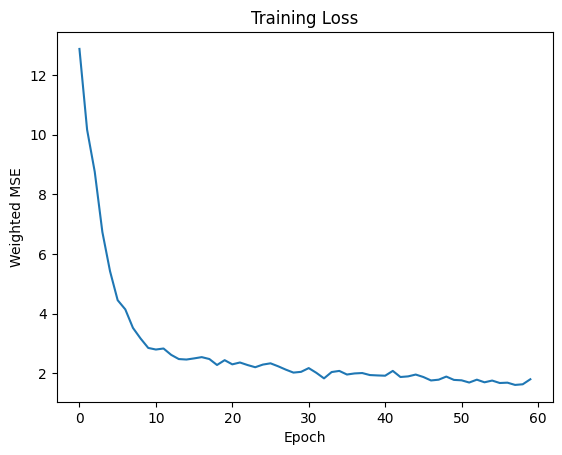

In [16]:
def weighted_mse_loss(pred, target, x1_data, weight_factor=10.0):
    """
    pred: Predicted Velocity
    target: Target Velocity (x1 - x0)
    x1_data: The REAL Quantum Data (used for importance weighting)
    """
    # In our specific quantum encoding:
    # Background (Empty) is approx +1.0
    # Signal (Jets) is approx -1.0
    
    # We want high weights for Signal (-1.0).
    # Formula: (1.0 - x1)
    # If x1 = +1 (Backg), val = 0.  Weight = 1.0
    # If x1 = -1 (Signal), val = 2.  Weight = 1 + 2*Factor
    
    importance = (1.0 - x1_data)
    # Clamp to avoid any weird numerical spikes, though unlikely with tanh/cos
    importance = torch.clamp(importance, min=0.0)
    
    weights = 1.0 + (weight_factor * importance)
    
    diff = (pred - target) ** 2
    
    # Check for NaNs just in case
    if torch.isnan(diff).any():
        print("NaN detected in difference calculation")
        return torch.tensor(0.0, device=pred.device, requires_grad=True)

    return (diff * weights).mean()

# Re-initialize model to clear any bad gradients from the failed run
model = UNet(in_ch=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Slightly lower LR for stability

print("Training Flow Matching Model...")
losses = []

for epoch in range(1, 61):
    model.train()
    batch_loss = 0.0
    
    for (x1,) in gen_loader:
        x1 = x1.to(device)
        B = x1.shape[0]
        
        x0 = torch.randn_like(x1)
        t = torch.rand(B, device=device)
        
        t_view = t.view(B, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        target_v = x1 - x0
        
        pred_v = model(x_t, t)
        
        # FIX: Pass x1 (data) explicitly for weighting
        loss = weighted_mse_loss(pred_v, target_v, x1_data=x1, weight_factor=10.0)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        batch_loss += loss.item()
    
    avg_loss = batch_loss / len(gen_loader)
    losses.append(avg_loss)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss {avg_loss:.6f}")

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Weighted MSE")
plt.show()

Generating raw samples (no cleaning)...


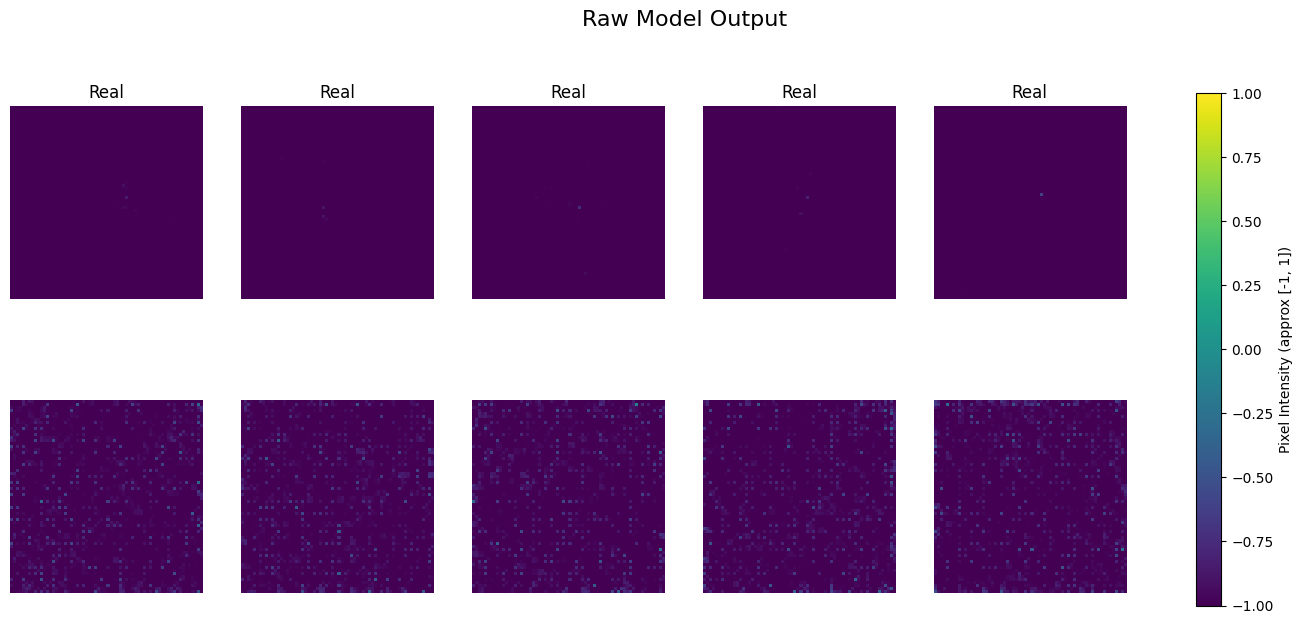

In [28]:
# %%
# [DEBUG: RAW SAMPLING]

@torch.no_grad()
def sample_raw(model, decoder, n_samples=10):
    model.eval()
    # 1. Start from Gaussian noise
    x = torch.randn(n_samples, 4, 32, 32, device=device)
    
    # 2. Integrate ODE
    steps = 50
    dt = 1.0 / steps
    for i in range(steps):
        t_val = i / steps
        t_batch = torch.full((n_samples,), t_val, device=device)
        v = model(x, t_batch)
        x = x + v * dt

    # 3. Decode (No thresholding)
    raw_images = decoder(x)
    return raw_images.cpu().numpy()

# Generate
print("Generating raw samples (no cleaning)...")
raw_fake = sample_raw(model, decoder, n_samples=10)
real_imgs = data_X[:10]

# Plot
fig, axs = plt.subplots(2, 5, figsize=(18, 7))
# Use a common normalization to compare 'loudness' of features
vmin, vmax = -1.0, 1.0 

for i in range(5):
    # Real
    im1 = axs[0, i].imshow(real_imgs[i].squeeze(), vmin=vmin, vmax=vmax)
    axs[0, i].set_title(f"Real")
    axs[0, i].axis('off')
    
    # Fake (Raw)
    # We plot the raw output directly
    im2 = axs[1, i].imshow(raw_fake[i].squeeze(), vmin=vmin, vmax=vmax)
    axs[1, i].axis('off')

# Add colorbar to understand the values
cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.95)
cbar.set_label("Pixel Intensity (approx [-1, 1])")
plt.suptitle("Raw Model Output", fontsize=16)
plt.show()

Generating...


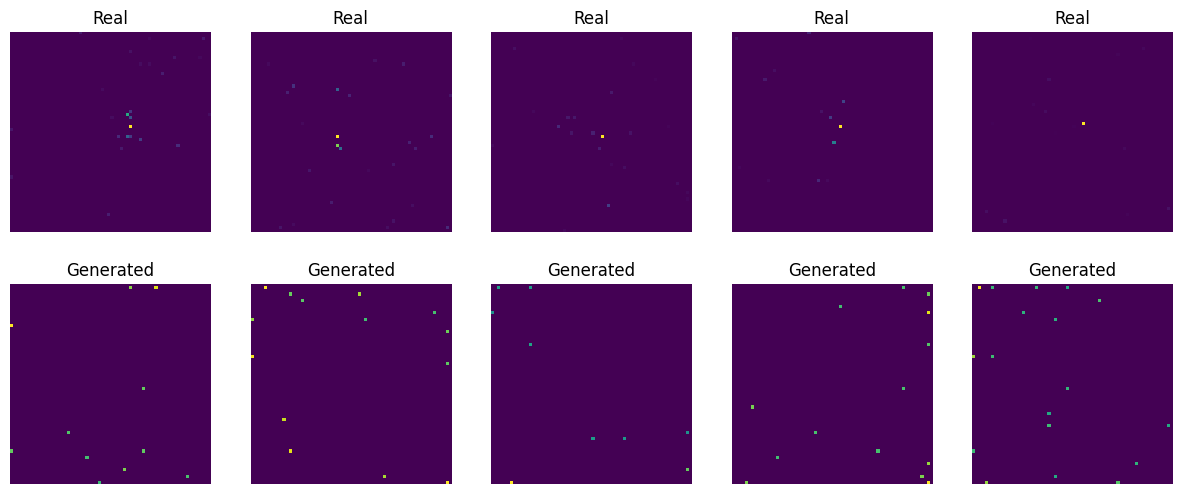

In [ ]:
@torch.no_grad()
def sample_and_clean(model, decoder, n_samples=16):
    model.eval()
    x = torch.randn(n_samples, 4, 32, 32, device=device)
    
    steps = 50
    dt = 1.0 / steps
    
    for i in range(steps):
        t_val = i / steps
        t_batch = torch.full((n_samples,), t_val, device=device)
        v = model(x, t_batch)
        x = x + v * dt

    # Decode
    images = decoder(x) # Output is approx [-1, 1]
    
    # Real data has background at -1
    # Decoder might give -0.9, -0.8
    # We threshold anything below -0.8 to be exactly -1.0
    images_clean = torch.where(images < -0.5, torch.tensor(-1.0, device=device), images)
    
    return images_clean.cpu().numpy()

print("Generating...")
fake_imgs = sample_and_clean(model, decoder, n_samples=100)
real_imgs = data_X[:100]

# Visualize
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow((real_imgs[i].squeeze()+1)/2)
    axs[0, i].set_title("Real")
    axs[0, i].axis('off')
    
    axs[1, i].imshow((fake_imgs[i].squeeze()+1)/2)
    axs[1, i].set_title("Generated")
    axs[1, i].axis('off')
plt.show()